In [ ]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.v2 as tfs
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch import seed_everything

In [ ]:
@dataclass
class CFG:
    seed: int = 42
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    lr_fc: float = 1e-3
    batch_size: int = 128
    num_workers: int = 2
    data_dir: str = 'data/DATASET'
    models_dir: str = 'models'
    unfreeze_epoch: int = 10
    lr_backbone: int = 1e-4
    
cfg = CFG()
seed_everything(cfg.seed)

In [3]:
def image_preview(img: np.ndarray):
    """Предпросмотр изображений
    """
    img_transpose = np.transpose(img, (1, 2, 0))
    # Нормализуем значения в диапазон от 0 до 255
    img_transpose_normalized = ((img_transpose - img_transpose.min()) / (img_transpose.max() - img_transpose.min()) * 255).astype(np.uint8)
    plt.imshow(img_transpose_normalized)

In [4]:
train_transforms = tfs.Compose([tfs.RandomRotation(30),
                                      tfs.RandomResizedCrop(224),
                                      tfs.RandomHorizontalFlip(),
                                      tfs.ToTensor(),
                                      tfs.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
test_transforms = tfs.Compose([tfs.Resize(255),
                                     tfs.CenterCrop(224),
                                     tfs.ToTensor(),
                                     tfs.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

/opt/anaconda/envs/fastai/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
train_data = datasets.ImageFolder(cfg.data_dir+'/TRAIN', transform=train_transforms)
val_data = datasets.ImageFolder(cfg.data_dir+'/VAL', transform=test_transforms)
test_data = datasets.ImageFolder(cfg.data_dir+'/TEST', transform=test_transforms)

In [6]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True)

In [7]:
dataiter = iter(train_loader)
im, lab = next(dataiter)
im = im.numpy()

In [8]:
im.shape

(128, 3, 224, 224)

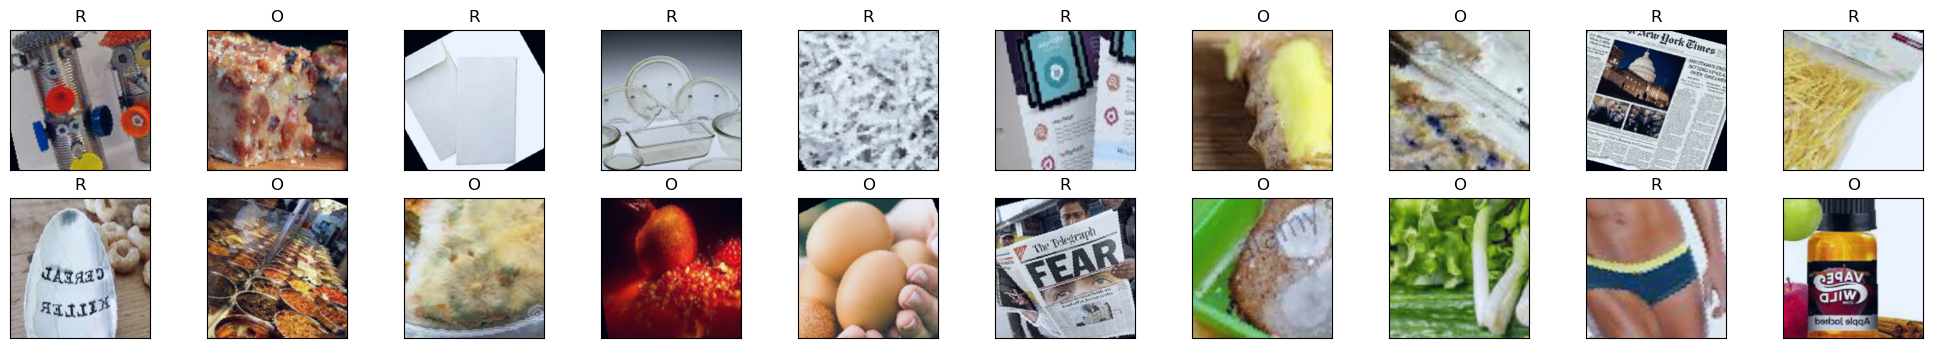

In [9]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    image_preview(im[idx])
    ax.set_title(train_data.classes[lab[idx]])

In [10]:
class WasteClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')  #(B, 3, H, W) -> (B, 32, H, W)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same') #(B, 32, H, W) -> (B, 64, H, W)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        
        self.dropout = nn.Dropout(.5)
        
        self.fc1 = nn.Linear(128*56*56, 256)
        self.fc2 = nn.Linear(256, 2)
        
    def forward(self, x):
        import pdb; pdb.set_trace()
        x = F.relu(self.conv1(x)) # (32, 224, 224)
        x = F.relu(self.conv2(x)) #(64, 224, 224)
        x = self.pool(x) #(64, 112, 112)
        
        x = F.relu(self.conv3(x)) #(128, 112, 112)
        x = F.relu(self.conv4(x)) #(128, 112, 112)
        x = self.pool(x) #(128, 56, 56)
        
        x = x.view(x.size(0), -1) #flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [17]:
model.fc.in_features

512

In [ ]:
class WasteLitModel(LightningModule):
    def __init__(self, unfreeze_epoch=10, lr_fc=1e-3, lr_backbone=1e-4):
        super().__init__()
        
        self.lr_fc = lr_fc
        self.lr_backbone = lr_backbone
        self.backbone_unfrozen = False  # чтобы не разморозить дважды
        self.unfreeze_epoch = unfreeze_epoch

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        #self.model = torch.compile(model)
        for param in self.model.parameters():
          param.requires_grad = False
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)
        for param in self.model.fc.parameters():
          param.requires_grad = True

        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def basic_step(self, batch, batch_idx, stage):
        x, y = batch
        preds = self(x)
        loss = self.loss(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_acc", acc, prog_bar=True)
        return loss

    def on_train_epoch_start(self):
        if (self.current_epoch == self.unfreeze_epoch) and not self.backbone_unfrozen:
          for param in self.model.parameters():
            param.requires_grad = True
          self.backbone_unfrozen = True
    
    def training_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.basic_step(batch, batch_idx, 'test')
    
    def configure_optimizers(self):
        if not self.backbone_unfrozen:
          return optim.Adam(self.parameters(), lr=self.lr_fc)
        else:
          return optim.Adam([
              {"params": self.model.fc.parameters(), "lr": self.lr_fc},
              {"params": [p for n, p in self.model.named_parameters() if "fc" not in n], "lr": self.lr_backbone}
          ])


In [ ]:
checkpoint_cb = ModelCheckpoint(
        monitor="val_acc",
        mode="max",
        save_top_k=2,
        filename="waste-resnet18-{epoch:02d}-{val_acc:.4f}",
        dirpath=cfg.models_dir
)
early_stop_cb = EarlyStopping(monitor='val_acc', mode='max', patience=3)

model = WasteLitModel(unfreeze_epoch=10, lr_fc=1e-3, lr_backbone=1e-4)
trainer = Trainer(
    max_epochs=10,
    precision=16,
    accelerator=cfg.device,
    callbacks=[
        checkpoint_cb,
        early_stop_cb,
        ]
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/opt/anaconda/envs/fastai/lib/python3.12/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/opt/anaconda/envs/fastai/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:513: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ResNet           | 11.2 M | train
1 | los

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined